## Training with Chainer

[VGG](https://arxiv.org/pdf/1409.1556v6.pdf) is an architecture for deep convolution networks. In this example, we train a convolutional network to perform image classification using the CIFAR-10 dataset. CIFAR-10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We'll train a model on SageMaker, deploy it to Amazon SageMaker hosting, and then classify images using the deployed model.

The Chainer script runs inside of a Docker container running on SageMaker. For more information about the Chainer container, see the sagemaker-chainer-containers repository and the sagemaker-python-sdk repository:

* https://github.com/aws/sagemaker-chainer-containers
* https://github.com/aws/sagemaker-python-sdk

For more on Chainer, please visit the Chainer repository:

* https://github.com/chainer/chainer

This notebook is adapted from the [CIFAR-10](https://github.com/chainer/chainer/tree/master/examples/cifar) example in the Chainer repository.

In [3]:
# Setup
from sagemaker import get_execution_role
import sagemaker

sagemaker_session = sagemaker.Session()

# This role retrieves the SageMaker-compatible role used by this Notebook Instance.
# role = get_execution_role()
role = 'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200530T112594'


## Downloading training and test data

We use helper functions provided by `chainer` to download and preprocess the CIFAR10 data. 

In [1]:
import chainer

from chainer.datasets import get_cifar10

train, test = get_cifar10()

In [2]:
train

## Uploading the data

We save the preprocessed data to the local filesystem, and then use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the S3 location, which we will use when we start the Training Job.

In [4]:
import os
import shutil

import numpy as np

train_data = [element[0] for element in train]
train_labels = [element[1] for element in train]

test_data = [element[0] for element in test]
test_labels = [element[1] for element in test]

bucket = 'md-labs-bucket'

try:
    os.makedirs('/tmp/data/train_cifar')
    os.makedirs('/tmp/data/test_cifar')
    np.savez('/tmp/data/train_cifar/train.npz', data=train_data, labels=train_labels)
    np.savez('/tmp/data/test_cifar/test.npz', data=test_data, labels=test_labels)
    train_input = sagemaker_session.upload_data(
                      bucket=bucket,
                      path=os.path.join('/tmp', 'data', 'train_cifar'),
                      key_prefix='md-labs-chainer_cifar/train')
    test_input = sagemaker_session.upload_data(
                      path=os.path.join('/tmp', 'data', 'test_cifar'),
                      key_prefix='md-labs-chainer_cifar/test')
finally:
    shutil.rmtree('/tmp/data')
print('training data at %s', train_input)
print('test data at %s', test_input)

training data at %s s3://md-labs-bucket/md-labs-chainer_cifar/train
test data at %s s3://sagemaker-us-east-2-868024899531/md-labs-chainer_cifar/test


## Writing the Chainer script to run on Amazon SageMaker

### Training

We need to provide a training script that can run on the SageMaker platform. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.
* `SM_OUTPUT_DIR`: A string representing the filesystem path to write output artifacts to. Output artifacts may
  include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed
  and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the Chainer estimator's ``fit()`` method,
the following will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: A string representing the path to the directory containing data in the 'train' channel
* `SM_CHANNEL_TEST`: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance. For example, the script run by this notebook starts with the following:

```python
import argparse
import os

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # retrieve the hyperparameters we set from the client (with some defaults)
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--learning-rate', type=float, default=0.05)

    # Data, model, and output directories These are required.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--test', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    
    args, _ = parser.parse_known_args()
    
    num_gpus = int(os.environ['SM_NUM_GPUS'])
    
    # ... load from args.train and args.test, train a model, write model to args.model_dir.
```

Because the Chainer container imports your training script, you should always put your training code in a main guard (`if __name__=='__main__':`) so that the container does not inadvertently run your training code at the wrong point in execution.

For more information about training environment variables, please visit https://github.com/aws/sagemaker-containers.

### Hosting and Inference

We use a single script to train and host the Chainer model. You can also write separate scripts for training and hosting. In contrast with the training script, the hosting script requires you to implement functions with particular function signatures (or rely on defaults for those functions).

These functions load your model, deserialize data sent by a client, obtain inferences from your hosted model, and serialize predictions back to a client:


* **`model_fn(model_dir)` (always required for hosting)**: This function is invoked to load model artifacts from those that were written into `model_dir` during training.

The script that this notebook runs uses the following `model_fn` function for hosting:
```python
def model_fn(model_dir):
    chainer.config.train = False
    model = L.Classifier(net.VGG(10))
    serializers.load_npz(os.path.join(model_dir, 'model.npz'), model)
    return model.predictor
```
* `input_fn(input_data, content_type)`: This function is invoked to deserialize prediction data when a prediction request is made. The return value is passed to predict_fn. `input_data` is the serialized input data in the body of the prediction request, and `content_type`, the MIME type of the data.
  
  
* `predict_fn(input_data, model)`: This function accepts the return value of `input_fn` as the `input_data` parameter and the return value of `model_fn` as the `model` parameter and returns inferences obtained from the model.
  
  
* `output_fn(prediction, accept)`: This function is invoked to serialize the return value from `predict_fn`, which is passed in as the `prediction` parameter, back to the SageMaker client in response to prediction requests.


`model_fn` is always required, but default implementations exist for the remaining functions. These default implementations can deserialize a NumPy array, invoking the model's `__call__` method on the input data, and serialize a NumPy array back to the client.

This notebook relies on the default `input_fn`, `predict_fn`, and `output_fn` implementations. See the Chainer sentiment analysis notebook for an example of how one can implement these hosting functions.

Please examine the script below. Training occurs behind the main guard, which prevents the function from being run when the script is imported, and `model_fn` loads the model saved into `model_dir` during training.



For more on writing Chainer scripts to run on SageMaker, or for more on the Chainer container itself, please see the following repositories: 

* For writing Chainer scripts to run on SageMaker: https://github.com/aws/sagemaker-python-sdk
* For more on the Chainer container and default hosting functions: https://github.com/aws/sagemaker-chainer-containers



In [ ]:
!pygmentize 'src/chainer_cifar_vgg_single_machine.py'

## Running the training script on SageMaker

To train a model with a Chainer script, we construct a ```Chainer``` estimator using the [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk). We pass in an `entry_point`, the name of a script that contains a couple of functions with certain signatures (`train` and `model_fn`), and a `source_dir`, a directory containing all code to run inside the Chainer container. This script will be run on SageMaker in a container that invokes these functions to train and load Chainer models. 

The ```Chainer``` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we will run our training job on one `ml.p2.xlarge` instance.

In [5]:
from sagemaker.chainer.estimator import Chainer

chainer_estimator = Chainer(entry_point='chainer_cifar_vgg_single_machine.py',
                            source_dir="src",
                            role=role,
                            sagemaker_session=sagemaker_session,
                            train_instance_count=1,
                            train_instance_type='ml.p2.xlarge',
                            hyperparameters={'epochs': 50, 'batch-size': 64})

chainer_estimator.fit({'train': train_input, 'test': test_input})

!=3.1.*,!=3.2.*,!=3.3.*), version: 19.1
  Found link https://files.pythonhosted.org/packages/51/5f/802a04274843f634469ef299fcd273de4438386deb7b8681dd059f0ee3b7/pip-19.1.tar.gz#sha256=d9137cb543d8a4d73140a3282f6d777b2e786bb6abb8add3ac5b6539c82cd624 (from https://pypi.org/simple/pip/) (requires-python:>=2.7,!=3.0.*,!=3.1.*,!=3.2.*,!=3.3.*), version: 19.1
  Found link https://files.pythonhosted.org/packages/5c/e0/be401c003291b56efc55aeba6a80ab790d3d4cece2778288d65323009420/pip-19.1.1-py2.py3-none-any.whl#sha256=993134f0475471b91452ca029d4390dc8f298ac63a712814f101cd1b6db46676 (from https://pypi.org/simple/pip/) (requires-python:>=2.7,!=3.0.*,!=3.1.*,!=3.2.*,!=3.3.*), version: 19.1.1
  Found link https://files.pythonhosted.org/packages/93/ab/f86b61bef7ab14909bd7ec3cd2178feb0a1c86d451bc9bccd5a1aedcde5f/pip-19.1.1.tar.gz#sha256=44d3d7d3d30a1eb65c7e5ff1173cdf8f7467850605ac7cc3707b6064bddd0958 (from https://pypi.org/simple/pip/) (requires-python:>=2.7,!=3.0.*,!=3.1.*,!=3.2.*,!=3.3.*), version: 

Our Chainer script writes various artifacts, such as plots, to a directory `output_data_dir`, the contents of which which SageMaker uploads to S3. Now we download and extract these artifacts.

In [6]:
from s3_util import retrieve_output_from_s3

chainer_training_job = chainer_estimator.latest_training_job.name

desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)

output_data = desc['ModelArtifacts']['S3ModelArtifacts'].replace('model.tar.gz', 'output.tar.gz')

retrieve_output_from_s3(output_data, 'output/single_machine_cifar')

These plots show the accuracy and loss over epochs:

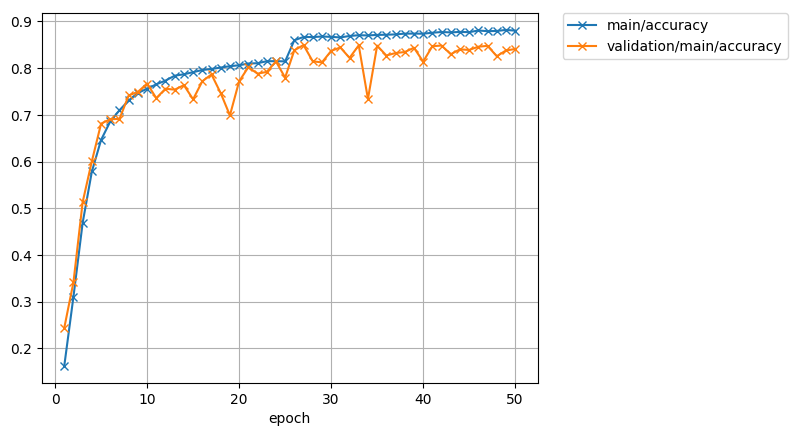

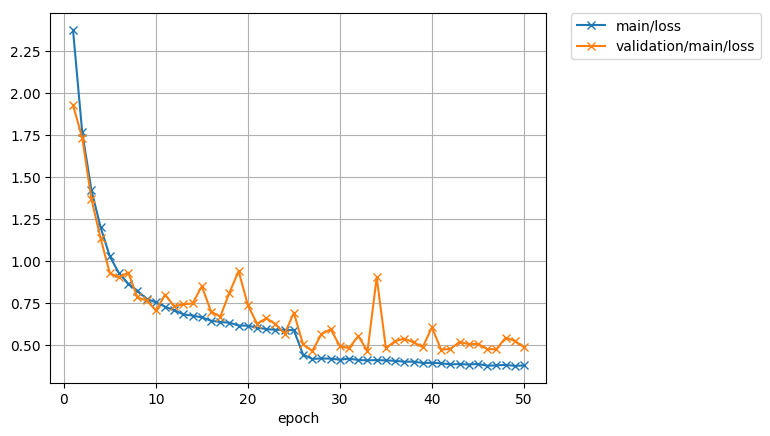

In [7]:
from IPython.display import Image
from IPython.display import display

accuracy_graph = Image(filename="output/single_machine_cifar/accuracy.png",
                       width=800,
                       height=800)
loss_graph = Image(filename="output/single_machine_cifar/loss.png",
                   width=800,
                   height=800)

display(accuracy_graph, loss_graph)

## Deploying the Trained Model

After training, we use the Chainer estimator object to create and deploy a hosted prediction endpoint. We can use a CPU-based instance for inference (in this case an `ml.m4.xlarge`), even though we trained on GPU instances.

The predictor object returned by `deploy` lets us call the new endpoint and perform inference on our sample images. 

In [8]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

### CIFAR10 sample images

We'll use these CIFAR10 sample images to test the service:

<img style="display: inline; height: 32px; margin: 0.25em" src="images/airplane1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/automobile1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/bird1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/cat1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/deer1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/dog1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/frog1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/horse1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/ship1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/truck1.png" />



## Predicting using SageMaker Endpoint

We batch the images together into a single NumPy array to obtain multiple inferences with a single prediction request.

In [11]:
import sys
! {sys.prefix}/bin/pip install scikit-image

     |████████████████████████████████| 12.4 MB 5.7 MB/s 
     |████████████████████████████████| 1.6 MB 5.6 MB/s 
     |████████████████████████████████| 2.1 MB 6.0 MB/s 
     |████████████████████████████████| 133 kB 4.5 MB/s 
     |████████████████████████████████| 4.4 MB 1.9 MB/s 
     |████████████████████████████████| 3.3 MB 3.0 MB/s 
     |████████████████████████████████| 20.1 MB 4.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3


In [12]:
from skimage import io
import numpy as np

def read_image(filename):
    img = io.imread(filename)
    img = np.array(img).transpose(2, 0, 1)
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)
    img *= 1. / 255.
    img = img.reshape(3, 32, 32)
    return img


def read_images(filenames):
    return np.array([read_image(f) for f in filenames])

filenames = ['images/airplane1.png',
             'images/automobile1.png',
             'images/bird1.png',
             'images/cat1.png',
             'images/deer1.png',
             'images/dog1.png',
             'images/frog1.png',
             'images/horse1.png',
             'images/ship1.png',
             'images/truck1.png']

image_data = read_images(filenames)

The predictor runs inference on our input data and returns a list of predictions whose argmax gives the predicted label of the input data. 

In [14]:
response = predictor.predict(image_data)

for i, prediction in enumerate(response):
    print('image {}: prediction: {}'.format(i, prediction.argmax(axis=0)))

image 0: prediction: 0
image 1: prediction: 1
image 2: prediction: 2
image 3: prediction: 3
image 4: prediction: 4
image 5: prediction: 5
image 6: prediction: 6
image 7: prediction: 7
image 8: prediction: 8
image 9: prediction: 9


## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [15]:
chainer_estimator.delete_endpoint()